In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit,cross_val_score
from sklearn.model_selection import cross_validate, GridSearchCV
from keras import models
from keras.models import Sequential
from keras.layers import Dense
import keras
from sklearn.tree import DecisionTreeClassifier

In [34]:
DP_train_df = pd.read_csv("Disease Prediction Training.csv")
DP_test_df = pd.read_csv("Disease Prediction Testing.csv")

# Section1: Data Preparation

## Potential data quality issue 

For some distance-based algorithms, normalization is required cause attributes in data set are in the same scale. Differece of unit impacts calculation of distance and makes it inaccurate.

To apply classification algorithms, all of the attributes should be the same type. A combination of numerical and categorical attributes is not allowed.

Missing value in the data set can also have a huge influence on the results.

Unvalidated data points. The data set contains index of normal human body, so there is normal range for these critirion. We need to do a research on them and figure out normal range and remove unvalidate data point out of the range.

## Data preprocessing

### Basic data cleaning

In [35]:
#test missing value
any(DP_train_df.isna().any())
any(DP_test_df.isna().any())
DP_train_df.dropna(inplace=True)
DP_test_df.dropna(inplace=True)
#remove duplicates()
DP_train_df.drop_duplicates(inplace=True)
DP_test_df.drop_duplicates(inplace=True)

### Data validation

In [36]:
#data validation remove outliers in Blood pressure
DP_train_df = DP_train_df[80 <= DP_train_df['High Blood Pressure']]
DP_train_df = DP_train_df[DP_train_df['High Blood Pressure'] <=200]
DP_train_df = DP_train_df[DP_train_df['Low Blood Pressure'] <=130]
DP_train_df = DP_train_df[DP_train_df['High Blood Pressure'] >= 40]

### Data converstion

Transform categorical attributes Glucose, Cholesterol, Gender into numeric by one-hot encoding.

In [37]:
#transfrom categorical attributes to numeric using one-hot encoder
#for naive bayes classifier
df = pd.concat([DP_train_df, pd.get_dummies(DP_train_df['Gender']),
                            pd.get_dummies(DP_train_df['Glucose'], prefix='Glucose'),
                            pd.get_dummies(DP_train_df['Cholesterol'], prefix='Cholesterol')
                            ], axis = 1)
df.drop(['Gender','Glucose','Cholesterol'], axis = 1, inplace = True)

### Train Test split

In [89]:
DP_train_X = df.drop('Disease', axis=1)
DP_train_Y = df['Disease']
X_train, X_test, Y_train, Y_test = train_test_split(DP_train_X, DP_train_Y, test_size = 0.3)

## Exploratory Data Analysis

### High Blood Pressure among different gender

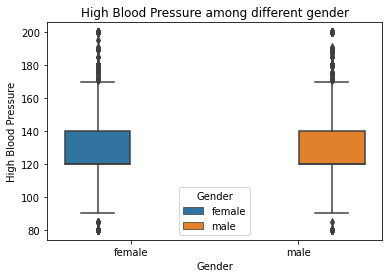

In [39]:
ax = sns.boxplot(y='High Blood Pressure', x='Gender', 
                 data=DP_train_df, hue = 'Gender')
plt.title("High Blood Pressure among different gender")
plt.show()

### Disease vs. non-disease

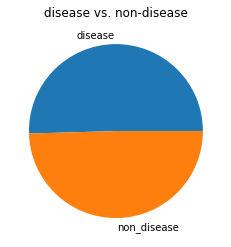

In [40]:
disease_count = DP_train_df[DP_train_df['Disease']==1].count()[0]
nondisease_count = DP_train_df[DP_train_df['Disease']==0].count()[0]
plt.figure()
plt.pie([disease_count,nondisease_count], labels=['disease','non_disease'])
plt.title("disease vs. non-disease")
plt.show()

# Section2:  Build, tune and evaluate various machine learning algorithms

## Logistic Regression

In [41]:
sc = StandardScaler()
lr = LogisticRegression(solver='lbfgs', random_state=8)
lr_pipe = make_pipeline(sc, lr)
lr_pipe.fit(X_train, Y_train)
lr_pred = lr_pipe.predict(X_test)
print(f"Logistic regression Accuracy: \n{round(metrics.accuracy_score(Y_test, lr_pred)*100,2)}%")

Logistic regression Accuracy: 
73.06%


## Hyperparameter tuning

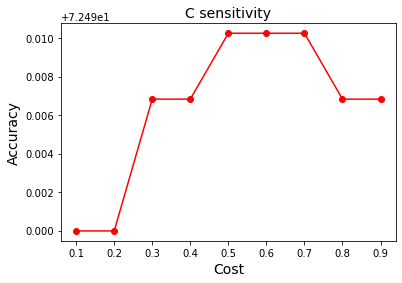

In [46]:
#manually tune C
#initialize C
cv = ShuffleSplit(n_splits=3,test_size=0.3,random_state=5)
C = np.arange(0.1,1,0.1)
accuracy_result_svm=[]
#for each C, construct model and calculate accuracy
for c in C:
    lr=LogisticRegression(solver = 'lbfgs', C = c,random_state=8)
    lr_pipe = make_pipeline(sc, lr)
    lr_pipe.fit(X_train, Y_train)
    #calculate cross validation score
    acc = cross_val_score(lr_pipe, X_train, Y_train, cv=cv).mean()*100
    accuracy_result_svm.append(acc)
plt.plot(C, accuracy_result_svm, color='red', marker='o')
plt.title('C sensitivity', fontsize=14)
plt.xlabel('Cost', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [47]:
sc = StandardScaler()
lr = LogisticRegression(solver='lbfgs', random_state=8, C = 0.6)
lr_pipe = make_pipeline(sc, lr)
lr_pipe.fit(X_train, Y_train)
lr_pred = lr_pipe.predict(X_test)
print(f"Logistic regression Accuracy after tuning: \n{round(metrics.accuracy_score(Y_test, lr_pred)*100,2)}%")

Logistic regression Accuracy after tuning: 
73.05%


## Feature Importance

In [99]:
weights = lr_pipe.named_steps['logisticregression'].coef_.flatten()

In [98]:
lr_importance = pd.DataFrame(list(zip(X_train.columns, weights)),columns=['Features','weights'] )
lr_importance

,Features,weights
0,Age,0.342125
1,Height,-0.020534
2,Weight,0.132242
3,High Blood Pressure,0.924167
4,Low Blood Pressure,0.120325
5,Smoke,-0.039315
6,Alcohol,-0.041354
7,Exercise,-0.076415
8,female,0.006627
9,male,-0.006627


## ANN

In [48]:
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [49]:
#ANN 0
ANN_0 = Sequential()
ANN_0.add(Dense(6, activation='relu'))
ANN_0.add(Dense(1, activation='sigmoid'))
ANN_0.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
ANN_0.fit(X_train, Y_train, epochs=10, batch_size=5, verbose=1)

Epoch 1/10
6487/6487 [==============================] - 3s 394us/step - loss: 0.5791 - accuracy: 0.7060
Epoch 2/10
6487/6487 [==============================] - 2s 382us/step - loss: 0.5547 - accuracy: 0.7266
Epoch 3/10
6487/6487 [==============================] - 2s 375us/step - loss: 0.5531 - accuracy: 0.7275
Epoch 4/10
6487/6487 [==============================] - 2s 383us/step - loss: 0.5519 - accuracy: 0.7267
Epoch 5/10
6487/6487 [==============================] - 3s 401us/step - loss: 0.5509 - accuracy: 0.7280
Epoch 6/10
6487/6487 [==============================] - 2s 375us/step - loss: 0.5504 - accuracy: 0.7280
Epoch 7/10
6487/6487 [==============================] - 2s 371us/step - loss: 0.5496 - accuracy: 0.7282
Epoch 8/10
6487/6487 [==============================] - 2s 371us/step - loss: 0.5496 - accuracy: 0.7299
Epoch 9/10
6487/6487 [==============================] - 2s 372us/step - loss: 0.5490 - accuracy: 0.7303
Epoch 10/10
6487/6487 [==============================] - 2s 375u

In [50]:
#ANN 1
ANN_1 = Sequential()
ANN_1.add(Dense(6, activation='relu', input_shape=(16, )))
ANN_1.add(Dense(6, activation='relu'))
ANN_1.add(Dense(1, activation='sigmoid'))
ANN_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
ANN_1.fit(X_train, Y_train, epochs=10, batch_size=5, verbose=1)

Epoch 1/10
32435/32435 [==============================] - 12s 371us/step - loss: 0.5626 - accuracy: 0.7201
Epoch 2/10
32435/32435 [==============================] - 12s 363us/step - loss: 0.5514 - accuracy: 0.7276
Epoch 3/10
32435/32435 [==============================] - 12s 355us/step - loss: 0.5497 - accuracy: 0.7284
Epoch 4/10
32435/32435 [==============================] - 12s 384us/step - loss: 0.5500 - accuracy: 0.7274
Epoch 5/10
32435/32435 [==============================] - 13s 387us/step - loss: 0.5506 - accuracy: 0.7285
Epoch 6/10
32435/32435 [==============================] - 12s 357us/step - loss: 0.5493 - accuracy: 0.7293
Epoch 7/10
32435/32435 [==============================] - 12s 355us/step - loss: 0.5493 - accuracy: 0.7294
Epoch 8/10
32435/32435 [==============================] - 11s 354us/step - loss: 0.5489 - accuracy: 0.7289
Epoch 9/10
32435/32435 [==============================] - 12s 356us/step - loss: 0.5488 - accuracy: 0.7291
Epoch 10/10
32435/32435 [============

In [51]:
#ANN 2
ANN_2 = Sequential()
ANN_2.add(Dense(6, activation='relu', input_shape=(16, )))
ANN_2.add(Dense(6, activation='relu'))
ANN_2.add(Dense(6, activation='relu'))
ANN_2.add(Dense(6, activation='relu'))
ANN_2.add(Dense(1, activation='sigmoid'))
ANN_2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
ANN_2.fit(X_train, Y_train, epochs=10, batch_size=5, verbose=1)

Epoch 1/10
32435/32435 [==============================] - 12s 380us/step - loss: 0.5625 - accuracy: 0.7211
Epoch 2/10
32435/32435 [==============================] - 12s 378us/step - loss: 0.5541 - accuracy: 0.7279
Epoch 3/10
32435/32435 [==============================] - 12s 378us/step - loss: 0.5520 - accuracy: 0.7272
Epoch 4/10
32435/32435 [==============================] - 13s 400us/step - loss: 0.5511 - accuracy: 0.7292
Epoch 5/10
32435/32435 [==============================] - 13s 398us/step - loss: 0.5503 - accuracy: 0.7283
Epoch 6/10
32435/32435 [==============================] - 13s 390us/step - loss: 0.5495 - accuracy: 0.7297
Epoch 7/10
32435/32435 [==============================] - 13s 411us/step - loss: 0.5499 - accuracy: 0.7291
Epoch 8/10
32435/32435 [==============================] - 13s 410us/step - loss: 0.5495 - accuracy: 0.7303
Epoch 9/10
32435/32435 [==============================] - 13s 406us/step - loss: 0.5492 - accuracy: 0.7280
Epoch 10/10
32435/32435 [============

## Hyperparameter tuning for ANN with 0 hidden node

In [52]:
#0 hidden layer hyperparameter tuning
def build_model_0(hp):
    model = keras.Sequential()
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [53]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
tuner_0 = RandomSearch(
    build_model_0,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,    
    directory='my_dir',
    project_name='0-hidden-layer-tuning')

INFO:tensorflow:Reloading Oracle from existing project my_dir/0-hidden-layer-tuning/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/0-hidden-layer-tuning/tuner0.json


In [54]:
tuner_0.search(X_train, Y_train,
             epochs=5,
             validation_data=(X_test, Y_test))

INFO:tensorflow:Oracle triggered exit


In [55]:
best_hp_0 = tuner_0.get_best_hyperparameters()[0]
ANN_0 = tuner_0.hypermodel.build(best_hp_0)

In [56]:
tuner_0.results_summary()

Results summary
Results in my_dir/0-hidden-layer-tuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
Score: 0.7253435254096985
Trial summary
Hyperparameters:
learning_rate: 0.0001
Score: 0.6914610266685486


## Hyperparameter tuning for ANN with 1 hidden node

In [57]:
#single layer hyperparameter tuning
def build_model_1(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=2,
                                        max_value=32,
                                        step=2),
                           activation=hp.Choice('activation',values = ['sigmoid','softmax','relu'])))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [64]:
tuner_1 = RandomSearch(
    build_model_1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='1-hidden layer tuning')

In [65]:
tuner_1.search(X_train, Y_train,
             epochs=5,
             validation_data=(X_test, Y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |22                |?                 
activation        |sigmoid           |?                 
learning_rate     |0.0001            |?                 

Epoch 1/5
1014/1014 [==============================] - 1s 701us/step - loss: 0.6643 - accuracy: 0.6137 - val_loss: 0.6364 - val_accuracy: 0.6734
Epoch 2/5
1014/1014 [==============================] - 1s 643us/step - loss: 0.6205 - accuracy: 0.6861 - val_loss: 0.6012 - val_accuracy: 0.7041
Epoch 3/5
1014/1014 [==============================] - 1s 626us/step - loss: 0.5939 - accuracy: 0.7052 - val_loss: 0.5799 - val_accuracy: 0.7156
Epoch 4/5
1014/1014 [==============================] - 1s 630us/step - loss: 0.5783 - accuracy: 0.7127 - val_loss: 0.5677 - val_accuracy: 0.7219
Epoch 5/5
1014/1014 [==============================] - 1s 654us/step - loss: 0.5697 - accuracy: 0.7162 - val_loss: 0.5606 - val_accuracy: 0.7256

Trial 1 Complete [

In [66]:
best_hp_1 = tuner_1.get_best_hyperparameters()[0]
ANN_1 = tuner_1.hypermodel.build(best_hp_1)

In [67]:
tuner_1.results_summary()

Results summary
Results in my_dir/1-hidden layer tuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 30
activation: softmax
learning_rate: 0.01
Score: 0.737213134765625
Trial summary
Hyperparameters:
units: 22
activation: sigmoid
learning_rate: 0.001
Score: 0.7334004640579224
Trial summary
Hyperparameters:
units: 22
activation: sigmoid
learning_rate: 0.0001
Score: 0.7255592942237854
Trial summary
Hyperparameters:
units: 22
activation: softmax
learning_rate: 0.0001
Score: 0.719732403755188
Trial summary
Hyperparameters:
units: 8
activation: relu
learning_rate: 0.0001
Score: 0.7099488973617554


## Hyperparameter with 2 hidden layers

In [68]:
#2 layer hyperparameter tuning
def build_model_2(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units = hp.Int('units',
                                        min_value=2,
                                        max_value=32,
                                        step=2),
                           activation = hp.Choice('activation',values = ['sigmoid','softmax','relu'])))
    model.add(layers.Dense(units = hp.Int('units',
                                        min_value=2,
                                        max_value=32,
                                        step=2),
                           activation = hp.Choice('activation',values = ['sigmoid','softmax','relu'])))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [69]:
tuner_2 = RandomSearch(
    build_model_2,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='2-hidden layer tuning')

In [70]:
tuner_2.search(X_train, Y_train,
             epochs=5,
             validation_data=(X_test, Y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |24                |?                 
activation        |sigmoid           |?                 
learning_rate     |0.0001            |?                 

Epoch 1/5
1014/1014 [==============================] - 1s 773us/step - loss: 0.6790 - accuracy: 0.5961 - val_loss: 0.6553 - val_accuracy: 0.6790
Epoch 2/5
1014/1014 [==============================] - 1s 720us/step - loss: 0.6332 - accuracy: 0.6929 - val_loss: 0.6088 - val_accuracy: 0.7102
Epoch 3/5
1014/1014 [==============================] - 1s 708us/step - loss: 0.5945 - accuracy: 0.7102 - val_loss: 0.5770 - val_accuracy: 0.7214
Epoch 4/5
1014/1014 [==============================] - 1s 684us/step - loss: 0.5737 - accuracy: 0.7173 - val_loss: 0.5628 - val_accuracy: 0.7260
Epoch 5/5
1014/1014 [==============================] - 1s 703us/step - loss: 0.5650 - accuracy: 0.7211 - val_loss: 0.5565 - val_accuracy: 0.7277

Trial 1 Complete [

In [72]:
best_hp_2 = tuner_2.get_best_hyperparameters()[0]
ANN_2 = tuner_2.hypermodel.build(best_hp_2)

AUC score: 
 0.5444744786780609


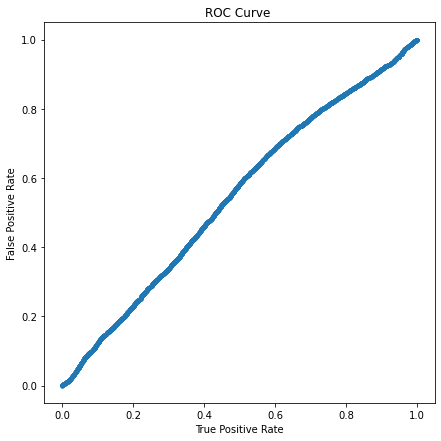

In [102]:
from sklearn.metrics import roc_curve, roc_auc_score
#predict the probability of the data points belongs to each class
ann_prob = ANN_2.predict_proba(sc.transform(X_test)).flatten()
#calculate false positve, true positive rate,
#known that roc curve is TP vs. FP
FP_rate, TP_rate, threshold = roc_curve(Y_test, ann_prob)
print("AUC score: \n" ,roc_auc_score(Y_test, ann_prob))
#plot roc curve
plt.subplots(1,figsize=(7,7))
plt.title("ROC Curve ")
plt.plot(FP_rate, TP_rate, marker='.')
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.show()

In [73]:
tuner_2.results_summary()

Results summary
Results in my_dir/2-hidden layer tuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 8
activation: softmax
learning_rate: 0.001
Score: 0.7372850775718689
Trial summary
Hyperparameters:
units: 32
activation: softmax
learning_rate: 0.01
Score: 0.7352708578109741
Trial summary
Hyperparameters:
units: 24
activation: sigmoid
learning_rate: 0.0001
Score: 0.7277174592018127
Trial summary
Hyperparameters:
units: 16
activation: sigmoid
learning_rate: 0.0001
Score: 0.7243363857269287
Trial summary
Hyperparameters:
units: 20
activation: softmax
learning_rate: 0.0001
Score: 0.7236170172691345


# Section3: Combination and Comparison of Multiple Machine Learning Algorithms 

## Decision Tree

In [74]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(f"Accuracy before hyperparameter tuning:{round(metrics.accuracy_score(Y_test,Y_pred)*100)}%")

Accuracy before hyperparameter tuning:63.0%


## Hyperparameter tuning

In [75]:
#condunct a hyperparameter tuning
param_grid = {'criterion':['gini','entropy'],
            'min_samples_split':[2,10,20],
             'max_depth':[5,10,20,25,30],
             'min_samples_leaf':[1,5,10],
             'max_leaf_nodes':[2,5,10,20]}
grid = GridSearchCV(clf, param_grid, cv = 10, scoring='accuracy')
grid.fit(X_train, Y_train)
print(f"Accuracy after hyperparameter tuning:{round(grid.best_score_*100)}%")

Accuracy after hyperparameter tuning:73.0%


In [76]:
print("Best parameters for decision tree algorithm are:")
for hps,values in grid.best_params_.items():
    print(f"{hps}:{values}")

Best parameters for decision tree algorithm are:
criterion:gini
max_depth:5
max_leaf_nodes:20
min_samples_leaf:10
min_samples_split:2


In [77]:
clf_best = DecisionTreeClassifier(criterion='gini',
                                 max_depth=5,
                                 max_leaf_nodes=20,
                                 min_samples_leaf=1,
                                 min_samples_split=2)
clf_best.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=20)

## Feature Importance

In [100]:
feature_importance = clf_best.feature_importances_
dt_importance = pd.DataFrame(list(zip(X_train.columns, feature_importance)),columns=['Features','Imporance'] )
dt_importance

,Features,Imporance
0,Age,0.116421
1,Height,0.001609
2,Weight,0.003058
3,High Blood Pressure,0.792580
4,Low Blood Pressure,0.002583
5,Smoke,0.003582
6,Alcohol,0.000000
7,Exercise,0.001670
8,female,0.000000
9,male,0.000000


# Section 4: Prediction and interpretation

In [78]:
#Data preparation
DP_test_df = DP_test_df[80 <= DP_test_df['High Blood Pressure']]
DP_test_df = DP_test_df[DP_test_df['High Blood Pressure'] <=200]
DP_test_df = DP_test_df[DP_test_df['Low Blood Pressure'] <=130]
DP_test_df = DP_test_df[DP_test_df['High Blood Pressure'] >= 40]
#transfrom categorical attributes to numeric using one-hot encoder
#for naive bayes classifier
DP_test = pd.concat([DP_test_df, pd.get_dummies(DP_test_df['Gender']),
                            pd.get_dummies(DP_test_df['Glucose'], prefix='Glucose'),
                            pd.get_dummies(DP_test_df['Cholesterol'], prefix='Cholesterol')
                            ], axis = 1)
DP_test.drop(['Gender','Glucose','Cholesterol'], axis = 1, inplace = True)
#select features to predict
DP_test_X = DP_test.drop('ID', axis=1)
X_test_std = sc.transform(DP_test_X)

In [79]:
#logistic regression 
lg = lr_pipe.predict(DP_test_X)

In [80]:
#ANN
ANN0 = ANN_0.predict_classes(X_test_std).flatten()
#ANN
ANN1 = ANN_1.predict_classes(X_test_std).flatten()
#ANN
ANN2 = ANN_2.predict_classes(X_test_std).flatten()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [81]:
#DT
DT = clf_best.predict(DP_test_X)

In [82]:
prediction_results = pd.DataFrame({'ID':DP_test['ID'],'DT':DT,
                     'LG':lg,'ANN0':ANN0,
                    'ANN1':ANN1,'ANN2':ANN2})

In [88]:
prediction_results.to_csv('hw04, prediction')